## Assignment #2

* Release date: 2021.10.12 Tue
* Due date: **2021.10.19 Tue 23:59** (will not accept late submission)
* Submission format: notebook file which can be executed in Colab environment
* Weighting: 5% (total 50 pts)
* You will build a multi-class classification model using Reuters dataset.

> ### Loading and preprocessing data

In [1]:
from tensorflow.keras.datasets import reuters

# Like IMDB, the argument num_words restricts the data to 
# the 10,000 most frequently occurring words 
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2121728/2110848 [==============================] - 0s 0us/step


* (10pts) Write the codes for preprocessing data
  * For inputs, the data we have should be converted to binary vectors.
  * For labels, determine an appropriate format by referring to the arguments of model.compile function below.

In [2]:
# write preprocessing codes


import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    #Create a matrix with size (sequences, dimension) and all elements zero.
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # Make the location of a specific index 1 in results[i].
    return results

train_data = vectorize_sequences(train_data) # Convert training data into vectors.
test_data = vectorize_sequences(test_data) # Convert test data into vectors.

train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')

> ### Building the network

In [3]:
# Do not modify this block
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [4]:
# Do not modify this block
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

> ### Validation

* We employ *k-fold cross validation* as validation method of our model.
* **(15pts)** Write a code in the below to perform *10-fold cross validation*.
* **For each fold, save a model at every epoch in your Google Drive.**

In [5]:
from keras.callbacks import ModelCheckpoint

def get_model_name(k):
    return '/{epoch:d}/K-fold_'+str(k)+'.h5'

k = 10
num_val_samples = len(train_data) // k
num_epochs = 15

train_acc_history = []
val_acc_history = []

save_dir = '/content/saved_models/'
s = np.arange(train_data.shape[0])

train_data = train_data[s]
train_labels = train_labels[s]

for i in range(k):

  print('processing fold #', i+1)
  val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
  val_targets = train_labels[i*num_val_samples: (i+1)*num_val_samples]
  
  partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                       train_data[(i+1)*num_val_samples:]],
                                      axis=0)
  partial_train_targets = np.concatenate([train_labels[:i*num_val_samples],
                                          train_labels[(i+1)*num_val_samples:]],
                                         axis=0)
    
  model_temp = model
  checkpointer = ModelCheckpoint(filepath=save_dir+get_model_name(i+1), verbose=0, monitor='val_loss', save_weights_only=False, save_best_only=False, mode='auto', save_freq='epoch') 

  history = model_temp.fit(partial_train_data, 
                      partial_train_targets,
                      validation_data=(val_data, val_targets),
                      epochs=num_epochs,
                      batch_size=20,
                      callbacks=[checkpointer])

  train_acc_history.append(history.history['accuracy'])
  val_acc_history.append(history.history['val_accuracy'])
 
 



processing fold # 1
Epoch 1/15
405/405 [==============================] - 5s 10ms/step - loss: 1.3689 - accuracy: 0.7023 - val_loss: 1.0371 - val_accuracy: 0.7851
Epoch 2/15
405/405 [==============================] - 4s 9ms/step - loss: 0.7302 - accuracy: 0.8402 - val_loss: 0.9248 - val_accuracy: 0.8140
Epoch 3/15
405/405 [==============================] - 4s 10ms/step - loss: 0.4741 - accuracy: 0.8986 - val_loss: 0.9209 - val_accuracy: 0.8185
Epoch 4/15
405/405 [==============================] - 4s 9ms/step - loss: 0.3383 - accuracy: 0.9240 - val_loss: 0.9768 - val_accuracy: 0.8174
Epoch 5/15
405/405 [==============================] - 4s 9ms/step - loss: 0.2632 - accuracy: 0.9400 - val_loss: 1.0783 - val_accuracy: 0.8140
Epoch 6/15
405/405 [==============================] - 4s 9ms/step - loss: 0.2279 - accuracy: 0.9487 - val_loss: 1.1382 - val_accuracy: 0.8096
Epoch 7/15
405/405 [==============================] - 4s 9ms/step - loss: 0.1972 - accuracy: 0.9539 - val_loss: 1.3631 - val_a

* **(10pts)** Plotting the training and validation accuracy
  * To obtain the validation accuracy at the end of every epoch, just average the performances of all folds.

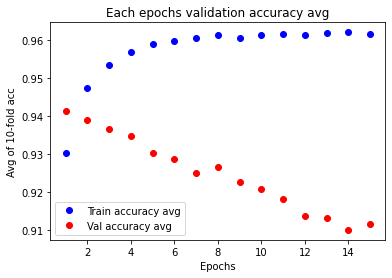

Val accuracy's max epoch point :  1


In [14]:
import matplotlib.pyplot as plt

avg_epoch_train = [np.mean([x[i] for x in train_acc_history]) for i in range(num_epochs)]
avg_epoch_val = [np.mean([x[i] for x in val_acc_history]) for i in range(num_epochs)]

max_point = avg_epoch_val.index(max(avg_epoch_val))+1
  
epoch_list = []
for i in range(num_epochs):
  epoch_list.append(i+1)

plt.plot(epoch_list, avg_epoch_train, 'bo', label='Train accuracy avg')
plt.plot(epoch_list, avg_epoch_val, 'ro', label='Val accuracy avg')

plt.title('Each epochs validation accuracy avg')
plt.xlabel('Epochs') 
plt.ylabel('Avg of 10-fold acc')
plt.legend()
plt.show()

print("Val accuracy's max epoch point : ",max_point)

* Find the best performance model by seeing the performance plot.
* Calculate the accuracy on test set using the best performance model.
  * Here, you should use a majority voting method to get the prediction for a test data point.
  * Specifically, given a test data point, get the predicted class from the trained model on each fold, and then decide the final predicted class by a majority voting.
* **Do not retrain the model.**

> ### (15pts) Inference

In [15]:
import pandas as pd

col_list = []
for i in range(len(test_labels)):
  col_list.append(i+1)

df = pd.DataFrame(columns=col_list)

for i in range(10):
  new_model = model
  new_model.load_weights("/content/saved_models/"+ str(max_point) +"/K-fold_"+str(i+1)+".h5")
  outcomes  = np.argmax(new_model.predict(test_data), axis=1)
  df.loc[i] = outcomes

# Hard voting
temp = df.mode()  
ensemble_labels = np.array(temp.loc[0].tolist())

from sklearn.metrics import accuracy_score

print("Majority voting model's score is", round(accuracy_score(test_labels, ensemble_labels),4))

Majority voting model's score is 0.7587


In [16]:
'''
models_list = []

for i in range(10):
  new_model = model
  new_model.load_weights("/content/saved_models/"+ str(max_point) +"/K-fold_"+str(i+1)+".h5")
  models_list.append(new_model) 

# make predictions
yhats = [model_temp.predict(test_data) for model_temp in models_list]
# sum across ensembles
summed = np.sum(yhats, axis=0)
# argmax across classes
outcomes = np.argmax(summed, axis=1)

from sklearn.metrics import accuracy_score

print("Soft voting model's score is", round(accuracy_score(test_labels, outcomes),4))
'''

Soft voting model's score is 0.6821
